In [ ]:
import kagglehub
path = kagglehub.dataset_download("ashishjangra27/face-mask-12k-images-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/face-mask-12k-images-dataset


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=f"{path}/Face Mask Dataset/Train", transform=train_transform)
val_dataset = datasets.ImageFolder(root=f"{path}/Face Mask Dataset/Validation", transform=test_transform)
test_dataset = datasets.ImageFolder(root=f"{path}/Face Mask Dataset/Test", transform=test_transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
import matplotlib.pyplot as plt
import warnings
import numpy as np
from tqdm.auto import tqdm

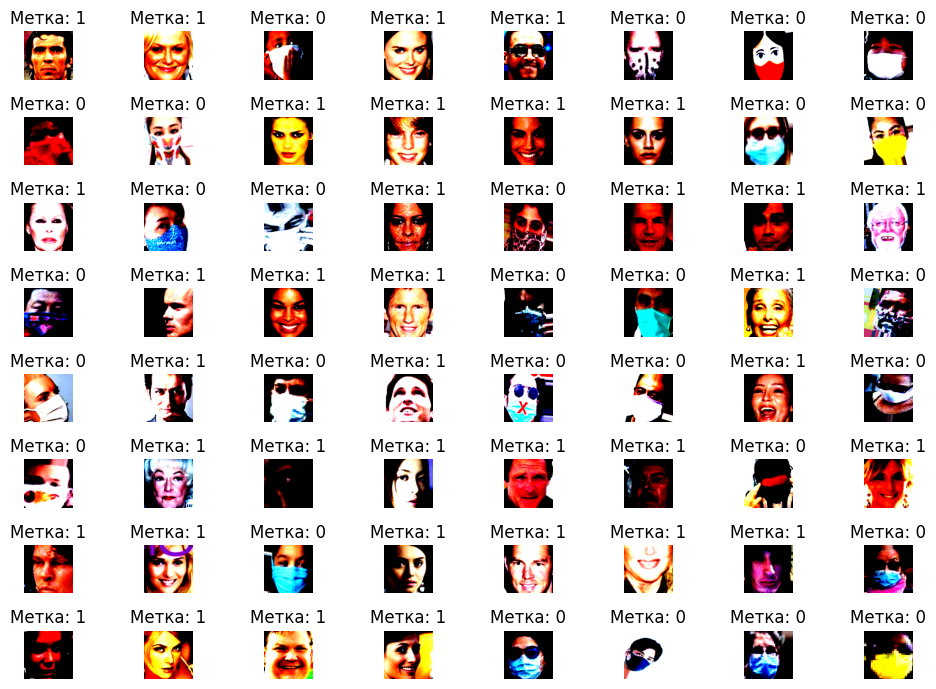

In [ ]:
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(8, 8, figsize=(10, 7))

for i in range(64):
    img = images[i].permute(1, 2, 0)
    row = i // 8
    col = i % 8
    axes[row, col].imshow(img, cmap='grey_r')
    axes[row, col].set_title(f"Метка: {labels[i].item()}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn.functional as F

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
def train(model, optimizer, criterion, epochs=2):
  for epoch in range(epochs):
    for x_train, y_train in tqdm(train_loader):
      x_train = x_train.to(device)
      y_train= y_train.to(device)
      y_pred = model(x_train)
      loss = criterion(y_pred, y_train)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      if epoch%2==0:
        val_loss =[]
        val_accuracy = []
        model.eval()
        with torch.no_grad():
          for x_val, y_val in tqdm(val_loader):
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_pred = model(x_val)
            loss = criterion(y_pred, y_val)
            val_loss.append(loss.cpu().numpy())
            val_accuracy.extend(
                        (torch.argmax(y_pred, dim=-1) == y_val).cpu().numpy().tolist()
                    )
        print(
                f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}"
            )

In [ ]:
from torchvision.models import resnet18
import torch.nn as nn

In [ ]:
model = resnet18()
model.fc = nn.Linear(model.fc.in_features, 2)

model.to(device)

optimizer = torch.optim.Adam(
    model.parameters(), lr=0.0001
)
print(
    f"Training model with {sum([x[1].numel() for x in model.named_parameters()])} parameters"
)
train(model, optimizer, F.cross_entropy)

Training model with 11177538 parameters


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 0, loss: 2.127289056777954, accuracy: 0.5


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 0, loss: 0.7664498686790466, accuracy: 0.5


KeyboardInterrupt: 

In [ ]:
def test_model_and_visualize(model, test_loader, class_names, device=device, grid_size=(8, 8)):
    model.eval()
    num_images = grid_size[0] * grid_size[1]
    images_shown = 0


    plt.figure(figsize=(20, 20))

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break

                image = images[i].cpu().permute(1, 2, 0).numpy()

                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                image = image * std + mean
                image = np.clip(image, 0, 1)

                true_label = class_names[labels[i].item()]
                pred_label = class_names[predicted[i].item()]
                plt.subplot(grid_size[0], grid_size[1], images_shown + 1)
                plt.imshow(image)
                plt.title(f'True: {true_label}\nPred: {pred_label}', fontsize=8)
                plt.axis('off')

                images_shown += 1


            if images_shown >= num_images:
                plt.tight_layout()
                plt.show()
                break



class_names = test_loader.dataset.classes
test_model_and_visualize(model, test_loader, class_names)